In [5]:
# Import the Required Packages
from tensorflow import keras
print('keras: ', keras.__version__)
import matplotlib.pyplot as plt
import random
import sys
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import numpy as np

keras:  3.6.0


## Step 1 – Data Loading and Processing

### 1.1 Data Loading

In [6]:
# read in the text file, transforming everything to lower case
text = open('./holmes.txt').read().lower()
print('The original text has ' + str(len(text)) + ' characters.\n')

The original text has 562439 characters.



### 1.2 Data Processing


In [7]:
### print out the first 1000 characters of the raw text to get a sense of what characters to remove
text[:2000]

"ï»¿the adventures of sherlock holmes by sir arthur conan doyle\n\n   i. a scandal in bohemia\n  ii. the red-headed league\n iii. a case of identity\n  iv. the boscombe valley mystery\n   v. the five orange pips\n  vi. the man with the twisted lip\n vii. the adventure of the blue carbuncle\nviii. the adventure of the speckled band\n  ix. the adventure of the engineer's thumb\n   x. the adventure of the noble bachelor\n  xi. the adventure of the beryl coronet\n xii. the adventure of the copper beeches\n\n\nadventure i. a scandal in bohemia\n\ni.\n\nto sherlock holmes she is always the woman. i have seldom heard\nhim mention her under any other name. in his eyes she eclipses\nand predominates the whole of her sex. it was not that he felt\nany emotion akin to love for irene adler. all emotions, and that\none particularly, were abhorrent to his cold, precise but\nadmirably balanced mind. he was, i take it, the most perfect\nreasoning and observing machine that the world has seen, but as a\

In [8]:
# remove all '\n' and '\r' from text
text = text.replace('\n','') 
text = text.replace('\r','')

In [9]:
# create a function 'clean_text' to clean text so that only the following letters and punctation remain
def clean_text(text):
    punctuation = ['!', ',', '.', ':', ';', '?', '-', "'",' ']
    letters='abcdefghijklmnopqrstuvwxyz'
    char_list = ""
    for i in text:
        if i in punctuation or i in letters:
            char_list += i
    return char_list

In [10]:
# clean data using clean_text function
text = clean_text(text)
text[:2000]

"the adventures of sherlock holmes by sir arthur conan doyle   i. a scandal in bohemia  ii. the red-headed league iii. a case of identity  iv. the boscombe valley mystery   v. the five orange pips  vi. the man with the twisted lip vii. the adventure of the blue carbuncleviii. the adventure of the speckled band  ix. the adventure of the engineer's thumb   x. the adventure of the noble bachelor  xi. the adventure of the beryl coronet xii. the adventure of the copper beechesadventure i. a scandal in bohemiai.to sherlock holmes she is always the woman. i have seldom heardhim mention her under any other name. in his eyes she eclipsesand predominates the whole of her sex. it was not that he feltany emotion akin to love for irene adler. all emotions, and thatone particularly, were abhorrent to his cold, precise butadmirably balanced mind. he was, i take it, the most perfectreasoning and observing machine that the world has seen, but as alover he would have placed himself in a false position. 

In [11]:
# count the number of unique characters in the text
chars = sorted(list(set(text)))
print(chars)

print ("This document has " +  str(len(text)) + " total number of characters.")
print ("This document has " +  str(len(chars)) + " unique characters.")

[' ', '!', "'", ',', '-', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
This document has 544340 total number of characters.
This document has 35 unique characters.


In [12]:
# create a function 'generate_text' to generate text inputs based on sequence_length and the corresponding labels
step = 3

def generate_text(text, maxlen):
    inputs = [] # store inputs
    labels = [] # stores label
    
    for i in range(0, len(text) - maxlen, step):
        inputs.append(text[i: i + maxlen]) 
        labels.append(text[i + maxlen])
    print('Number of sequences:', len(inputs))

    # List of unique characters in the corpus
    chars = sorted(list(set(text)))
    print('Unique characters:', len(chars))
    # Dictionary mapping unique characters to their index in `chars`
    char_indices = dict((char, chars.index(char)) for char in chars)
    
    return inputs, labels, char_indices, chars

In [13]:
# this dictionary is a function mapping each unique character to a unique integer
chars_to_indices = dict((c, i) for i, c in enumerate(chars))  # map each unique character to unique integer

# this dictionary is a function mapping each unique integer back to a unique character
indices_to_chars = dict((i, c) for i, c in enumerate(chars))  # map each unique integer back to unique character

In [14]:
# create a function 'encode_ohe_pairs' to perform one-hot encoding of inputs and labels
def encode_ohe_pairs(text, maxlen, inputs): # sequence_length determines # of characters in each input
    print('Vectorization...')
    x = np.zeros((len(inputs), maxlen, len(chars)), dtype=bool)
    y = np.zeros((len(inputs), len(chars)), dtype=bool)
    for i, sentence in enumerate(inputs):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
        y[i, char_indices[labels[i]]] = 1
    return x, y

In [16]:
# perform one-hot encoding of inputs and labels
# sequence_length = 100 # I attemped this for Model 1 to 7
sequence_length = 200 # I attempted this for Model 8 to 13 ## use this for model evaluation
# sequence_length = 150 I attempted this for Model 14
inputs, labels, char_indices, chars = generate_text(text, sequence_length)
print(inputs[0] + '\n' + labels[0])
X, y = encode_ohe_pairs(text, sequence_length, inputs)
print(X[0])
print(y[0])

Number of sequences: 181380
Unique characters: 35
the adventures of sherlock holmes by sir arthur conan doyle   i. a scandal in bohemia  ii. the red-headed league iii. a case of identity  iv. the boscombe valley mystery   v. the five orange pips  vi.
 
Vectorization...
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False]


In [12]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

### 1.3 Splitting Dataset into Inputs (X) and Labels (y)

## Step 2 – Develop a Character Generator Model

### Model #1 LSTM RMSprop Baseline Model for LSTM

In [14]:
# Build the Model
model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(sequence_length, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model.summary()

C:\Users\tswr1\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          83,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 35)                  │           4,515 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,483 (345.64 KB)

 Trainable params: 88,483 (345.64 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Lists to store accuracy and loss for training and validation
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

In [17]:
# Training the model

for epoch in range(1, 6): # 5 epochs
    print('epoch', epoch)
    
    # Fit the model for 1 epoch on the available training data
    history = model.fit(X, y, batch_size=128, epochs=1, validation_split=0.2)

    # Store training and validation metrics
    train_acc_list.append(history.history['acc'])
    train_loss_list.append(history.history['loss'])
    val_acc_list.append(history.history['val_acc'])
    val_loss_list.append(history.history['val_loss'])                        
    
    # Select a text seed at random
    start_index = random.randint(0, len(text) - sequence_length - 1)
    generated_text = text[start_index: start_index + sequence_length]
    print('--- Generating with seed: "' + generated_text + '"')
   
    
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # Generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, sequence_length, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 382s 331ms/step - acc: 0.2858 - loss: 2.5026 - val_acc: 0.4265 - val_loss: 1.9334
--- Generating with seed: "resume that this other goose upon the sideboard, which isabout the same weight and perfectly fresh, "
------ temperature: 0.2
resume that this other goose upon the sideboard, which isabout the same weight and perfectly fresh, a dear a store to the stould the canced a ded a for the can the cane the read the canced the can the was the canced the roun the refered a clack to be the read a better a stout the store the read the cours a clack a doon the stound the came to the read to the clowe to the canter to the read to the rought and which we come the canter to the come a clong to the canced the rought to the was to the ca
------ temperature: 0.5
ought and which we come the canter to the come a clong to the canced the rought to the was to the cagred a tore i weat the ame the cone sterked which a cance to charst and belowher wore been goon were 

In [18]:
# Flatten accuracy and loss lists
train_acc_plot = [j for i in train_acc_list for j in i]
train_loss_plot = [j for i in train_loss_list for j in i]
val_acc_plot = [j for i in val_acc_list for j in i]
val_loss_plot = [j for i in val_loss_list for j in i]

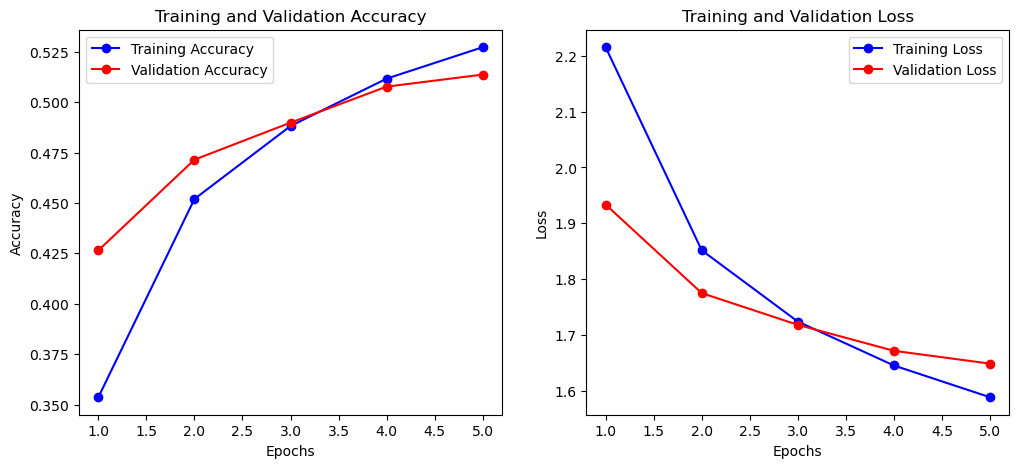

In [19]:
# Plot training and validation accuracy
epochs = range(1, len(train_acc_plot) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_plot, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc_plot, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_plot, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_plot, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [21]:
# Save the Model
model.save('char_rnn_model_1.keras')

### Model #2 LSTM RMSprop with 2 LSTM layers

In [ ]:
# Build the Model 2
model2 = keras.models.Sequential()
model2.add(layers.LSTM(128, return_sequences=True, input_shape=(sequence_length, len(chars))))
model2.add(layers.LSTM(128))
model2.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.RMSprop(learning_rate=0.01)
model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 100, 128)            │          83,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 35)                  │           4,515 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 220,067 (859.64 KB)

 Trainable params: 220,067 (859.64 KB)

 Non-trainable params: 0 (0.00 B)

Same learning rate, but I attempted increasing the number of LSTM layers. Increase complexity?

In [ ]:
# Lists to store accuracy and loss for training and validation
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

In [ ]:
# Training the model
for epoch in range(1, 6): # 5 epochs
    print('epoch', epoch)
    
    # Fit the model for 1 epoch on the available training data
    history = model2.fit(X, y, batch_size=128, epochs=1, validation_split=0.2)

    # Store training and validation metrics
    train_acc_list.append(history.history['acc'])
    train_loss_list.append(history.history['loss'])
    val_acc_list.append(history.history['val_acc'])
    val_loss_list.append(history.history['val_loss'])                        
    
    # Select a text seed at random
    start_index = random.randint(0, len(text) - sequence_length - 1)
    generated_text = text[start_index: start_index + sequence_length]
    print('--- Generating with seed: "' + generated_text + '"')
   
    
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # Generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, sequence_length, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model2.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 1791s 2s/step - acc: 0.2035 - loss: 2.8302 - val_acc: 0.3916 - val_loss: 2.0925
--- Generating with seed: "sitor by his left thumb, care about the finer shades ofanalysis and deduction! but, indeed, if you a"
------ temperature: 0.2
sitor by his left thumb, care about the finer shades ofanalysis and deduction! but, indeed, if you ar the rear the rears it it not een the lear the lare and the lered the land the keare and the lear to                                                                                                                                                                                                                                                                                                           
------ temperature: 0.5
                                                                                                                                                                                                           

As we can see here, the time taken to run each epoch has increased from 6 minutes per epoch to 15 minutes per epoch

In [ ]:
# Flatten accuracy and loss lists
train_acc_plot = [j for i in train_acc_list for j in i]
train_loss_plot = [j for i in train_loss_list for j in i]
val_acc_plot = [j for i in val_acc_list for j in i]
val_loss_plot = [j for i in val_loss_list for j in i]

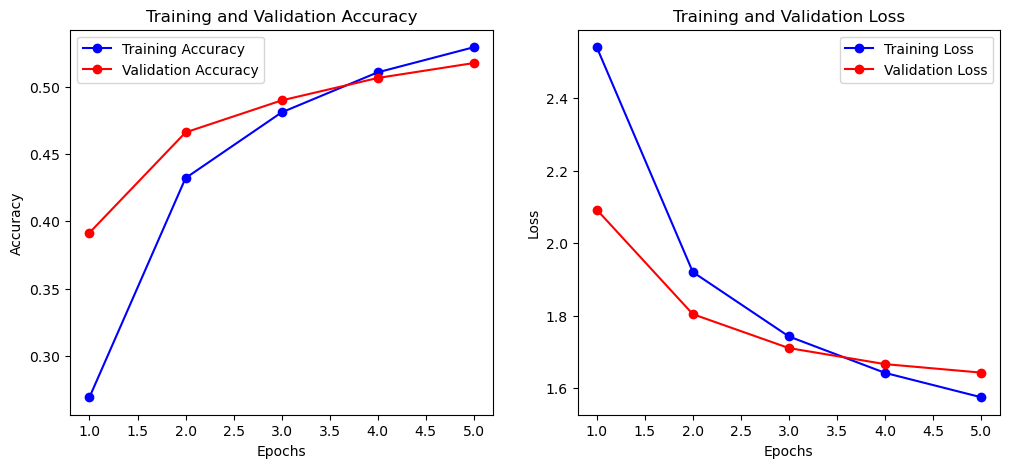

In [ ]:
# Plot training and validation accuracy
epochs = range(1, len(train_acc_plot) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_plot, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc_plot, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_plot, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_plot, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model2.save('char_rnn_model_2.keras')

### Model #3 LSTM Adam optimiser, single LSTM layer

In [ ]:
# Build the Model
model3 = keras.models.Sequential()
model3.add(layers.LSTM(128, input_shape=(sequence_length, len(chars))))
model3.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.01)
model3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model3.summary()

C:\Users\tswr1\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          83,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 35)                  │           4,515 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,483 (345.64 KB)

 Trainable params: 88,483 (345.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Lists to store accuracy and loss for training and validation
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

In [ ]:
# Training the model
for epoch in range(1, 6): # 5 epochs
    print('epoch', epoch)
    
    # Fit the model for 1 epoch on the available training data
    history = model3.fit(X, y, batch_size=128, epochs=1, validation_split=0.2)

    # Store training and validation metrics
    train_acc_list.append(history.history['acc'])
    train_loss_list.append(history.history['loss'])
    val_acc_list.append(history.history['val_acc'])
    val_loss_list.append(history.history['val_loss'])                        
    
    # Select a text seed at random
    start_index = random.randint(0, len(text) - sequence_length - 1)
    generated_text = text[start_index: start_index + sequence_length]
    print('--- Generating with seed: "' + generated_text + '"')
   
    
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # Generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, sequence_length, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model3.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 437s 377ms/step - acc: 0.3131 - loss: 2.3723 - val_acc: 0.4516 - val_loss: 1.8312
--- Generating with seed: "irely erroneous conclusion whichshows, my dear watson, how dangerous it always is to reason frominsu"
------ temperature: 0.2
irely erroneous conclusion whichshows, my dear watson, how dangerous it always is to reason frominsul a see it was the strent of the store and the been a see the to the been the been in the was the was the bear and i have been the becter of the been the lond a side and the was a see the pore the rear and he see the becter and to the was the was the marter and man the lond and the lond had been the bear to the been the better to the concer and the pore and the was the bent of the lond the leater 
------ temperature: 0.5
 bear to the been the better to the concer and the pore and the was the bent of the lond the leater of the cobles of the with some just was a small rear of the corner in the not preed about me and the 

In [ ]:
# Flatten accuracy and loss lists
train_acc_plot = [j for i in train_acc_list for j in i]
train_loss_plot = [j for i in train_loss_list for j in i]
val_acc_plot = [j for i in val_acc_list for j in i]
val_loss_plot = [j for i in val_loss_list for j in i]

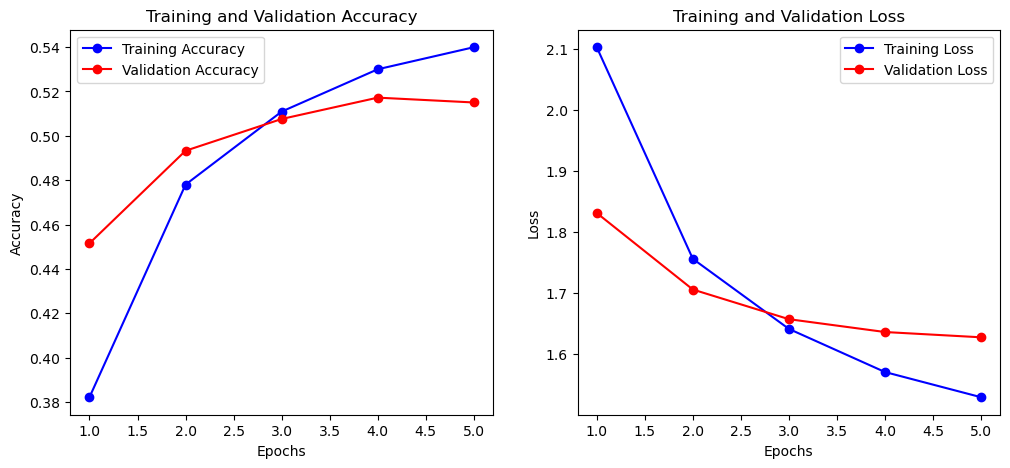

In [ ]:
# Plot training and validation accuracy
epochs = range(1, len(train_acc_plot) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_plot, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc_plot, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_plot, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_plot, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model3.save('char_rnn_model_3.keras')

### Model #4 LSTM Adam, increase the learning rate and 2 LSTM layers

In [ ]:
# Build the Model
model4 = keras.models.Sequential()
model4.add(layers.LSTM(64, return_sequences=True, input_shape=(sequence_length, len(chars))))
model4.add(layers.LSTM(64))
model4.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.05)
model4.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model4.summary()

C:\Users\tswr1\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 64)             │          25,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 35)                  │           2,275 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,899 (237.89 KB)

 Trainable params: 60,899 (237.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Lists to store accuracy and loss for training and validation
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

In [ ]:
# Training the model
for epoch in range(1, 6): # 5 epochs
    print('epoch', epoch)
    
    # Fit the model for 1 epoch on the available training data
    history = model4.fit(X, y, batch_size=128, epochs=1, validation_split=0.2)

    # Store training and validation metrics
    train_acc_list.append(history.history['acc'])
    train_loss_list.append(history.history['loss'])
    val_acc_list.append(history.history['val_acc'])
    val_loss_list.append(history.history['val_loss'])                        
    
    # Select a text seed at random
    start_index = random.randint(0, len(text) - sequence_length - 1)
    generated_text = text[start_index: start_index + sequence_length]
    print('--- Generating with seed: "' + generated_text + '"')
   
    
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # Generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, sequence_length, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model4.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 368s 324ms/step - acc: 0.4240 - loss: 1.9400 - val_acc: 0.4328 - val_loss: 1.8897
--- Generating with seed: "may walk to the cab,and i shall be with you presently.it was about ten minutes before we regained ou"
------ temperature: 0.2
may walk to the cab,and i shall be with you presently.it was about ten minutes before we regained out the was the will we was of the doon the was had the was and the was was from the sent the was have to the was the was was on the have to the will the will the was were in the was had the doon the was in the would the was the manne in of the was of the doon the will the face to my be on the will the was and the was will the was were were and the was were and the was were were were on the will the
------ temperature: 0.5
e was and the was will the was were were and the was were and the was were were were on the will the vens in our lemed the all of the was will we in the was one said he handmr. to face you to the was w

Unlike using the RMSprop optimizer in Models 1 and 2, the difference in time taken to run one epoch is not significant, even after adding another LSTM layer. The time difference is just 1 minute.

In [ ]:
# Flatten accuracy and loss lists
train_acc_plot = [j for i in train_acc_list for j in i]
train_loss_plot = [j for i in train_loss_list for j in i]
val_acc_plot = [j for i in val_acc_list for j in i]
val_loss_plot = [j for i in val_loss_list for j in i]

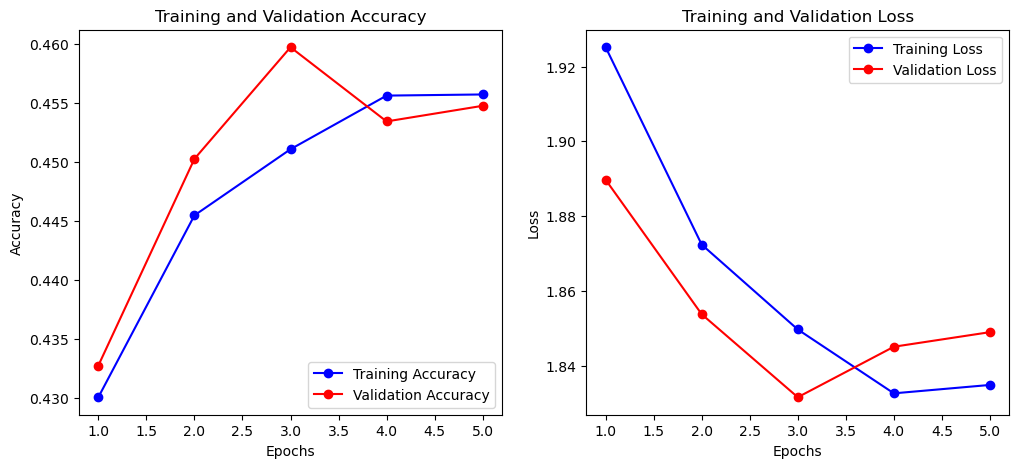

In [ ]:
# Plot training and validation accuracy
epochs = range(1, len(train_acc_plot) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_plot, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc_plot, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_plot, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_plot, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model4.save('char_rnn_model_4.keras')

### Model #5 GRU RMSprop Baseline Model for GRU

In [23]:
# Build the Model
model5 = keras.models.Sequential()
model5.add(layers.GRU(128, input_shape=(sequence_length, len(chars))))
model5.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.RMSprop(learning_rate=0.01)
model5.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model5.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 128)                 │          63,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 35)                  │           4,515 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,875 (265.14 KB)

 Trainable params: 67,875 (265.14 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Lists to store accuracy and loss for training and validation
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

In [25]:
# Training the model
for epoch in range(1, 6): # 5 epochs
    print('epoch', epoch)
    
    # Fit the model for 1 epoch on the available training data
    history = model5.fit(X, y, batch_size=128, epochs=1, validation_split=0.2)

    # Store training and validation metrics
    train_acc_list.append(history.history['acc'])
    train_loss_list.append(history.history['loss'])
    val_acc_list.append(history.history['val_acc'])
    val_loss_list.append(history.history['val_loss'])                        
    
    # Select a text seed at random
    start_index = random.randint(0, len(text) - sequence_length - 1)
    generated_text = text[start_index: start_index + sequence_length]
    print('--- Generating with seed: "' + generated_text + '"')
   
    
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # Generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, sequence_length, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model5.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 368s 319ms/step - acc: 0.3443 - loss: 2.2565 - val_acc: 0.4558 - val_loss: 1.8279
--- Generating with seed: " in the music at st. james's hall ifelt that an evil time might be coming upon those whom he had set"
------ temperature: 0.2
 in the music at st. james's hall ifelt that an evil time might be coming upon those whom he had set it was a marked the stone of the soor was a partaring to be and the toor have been we to may be one of the man and that it was and a pare to my as a partared to the attered to be may be was and to the betrees of the man and the man it was a poors. i have been it was and the come and a poored to be was and the conders and the badker and to that it was a pappersing to be the bedored it was a bright
------ temperature: 0.5
was and the conders and the badker and to that it was a pappersing to be the bedored it was a bright the my way to be was on the betreal the browe to my distoness, so surping endice and all the signess

In [26]:
# Flatten accuracy and loss lists
train_acc_plot = [j for i in train_acc_list for j in i]
train_loss_plot = [j for i in train_loss_list for j in i]
val_acc_plot = [j for i in val_acc_list for j in i]
val_loss_plot = [j for i in val_loss_list for j in i]

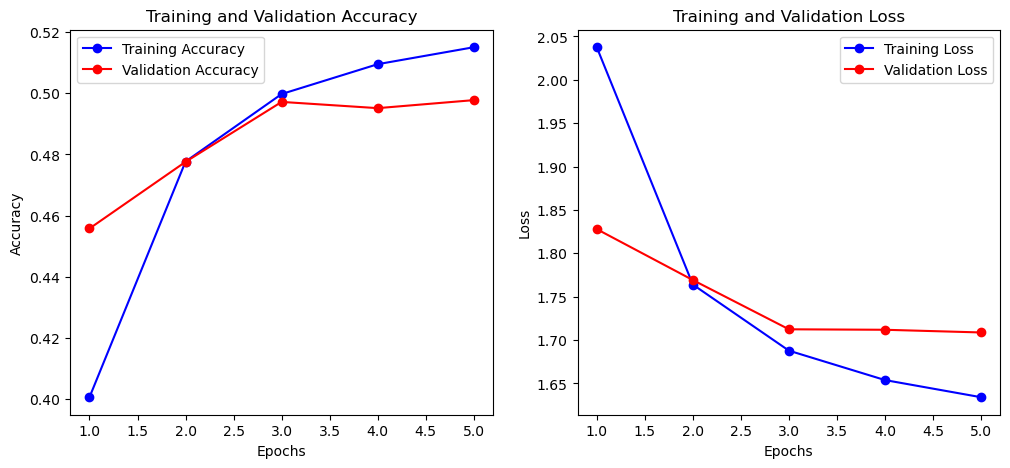

In [27]:
# Plot training and validation accuracy
epochs = range(1, len(train_acc_plot) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_plot, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc_plot, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_plot, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_plot, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [29]:
# Save the Model
model5.save('char_rnn_model_5.keras')

### Model #6 GRU RMSprop, 2 layers, dropout, and recurrent dropout

In [ ]:
# Build the Model
model6 = keras.models.Sequential()
model6.add(layers.GRU(128,return_sequences=True, input_shape=(sequence_length, len(chars))))
model6.add(layers.GRU(64, dropout = 0.1, recurrent_dropout = 0.1))
model6.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.RMSprop(learning_rate=0.01)
model6.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model6.summary()

C:\Users\tswr1\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 100, 128)            │          63,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 35)                  │           2,275 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,883 (401.89 KB)

 Trainable params: 102,883 (401.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Lists to store accuracy and loss for training and validation
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

In [ ]:
# Training the model
for epoch in range(1, 6): # 5 epochs
    print('epoch', epoch)
    
    # Fit the model for 1 epoch on the available training data
    history = model6.fit(X, y, batch_size=128, epochs=1, validation_split=0.2)

    # Store training and validation metrics
    train_acc_list.append(history.history['acc'])
    train_loss_list.append(history.history['loss'])
    val_acc_list.append(history.history['val_acc'])
    val_loss_list.append(history.history['val_loss'])                        
    
    # Select a text seed at random
    start_index = random.randint(0, len(text) - sequence_length - 1)
    generated_text = text[start_index: start_index + sequence_length]
    print('--- Generating with seed: "' + generated_text + '"')
   
    
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # Generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, sequence_length, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model6.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 805s 693ms/step - acc: 0.3001 - loss: 3.1152 - val_acc: 0.4442 - val_loss: 1.8721
--- Generating with seed: "t intothe bright morning sunshine. in the road stood our horse andtrap, with the half-clad stable-bo"
------ temperature: 0.2
t intothe bright morning sunshine. in the road stood our horse andtrap, with the half-clad stable-bore the been courd been a do not stark the can been it so a day the parlow so the was a do not the was a do not the canting and was a do not the caster oft been oft the pare the can and which a do not it was a sough a dear the was a do not it see had been of the was a sunder oft so the been oft the bust as it as a do not in the partion the been of the been of the caster oft was a dead been the can 
------ temperature: 0.5
ust as it as a do not in the partion the been of the been of the caster oft was a dead been the can oft the should do not be not that the pastance. i was a dered noting at the handing it was and at and

In [ ]:
# Flatten accuracy and loss lists
train_acc_plot = [j for i in train_acc_list for j in i]
train_loss_plot = [j for i in train_loss_list for j in i]
val_acc_plot = [j for i in val_acc_list for j in i]
val_loss_plot = [j for i in val_loss_list for j in i]

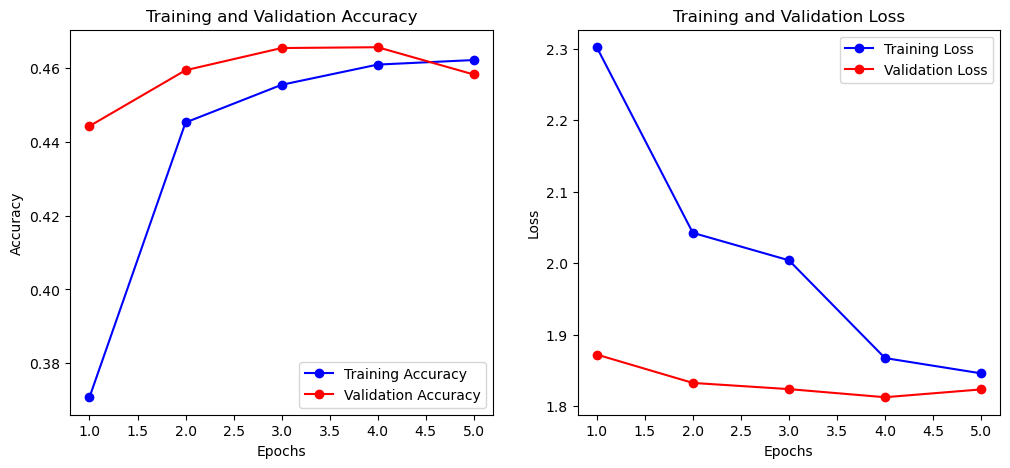

In [ ]:
# Plot training and validation accuracy
epochs = range(1, len(train_acc_plot) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_plot, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc_plot, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_plot, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_plot, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

definitely took longer as compared to model 5, twice the time taken to run one epoch. 5 minutes per epoch increased to 10 minutes

In [ ]:
# Save the Model
model6.save('char_rnn_model_6.keras')

### Model #7 GRU Adam Single layer

In [ ]:
# Build the Model
model7 = keras.models.Sequential()
model7.add(layers.GRU(128, input_shape=(sequence_length, len(chars))))
model7.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.01)
model7.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model7.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 128)                 │          63,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 35)                  │           4,515 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,875 (265.14 KB)

 Trainable params: 67,875 (265.14 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Lists to store accuracy and loss for training and validation
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

In [ ]:
# Training the model
for epoch in range(1, 6): # 5 epochs
    print('epoch', epoch)
    
    # Fit the model for 1 epoch on the available training data
    history = model7.fit(X, y, batch_size=128, epochs=1, validation_split=0.2)

    # Store training and validation metrics
    train_acc_list.append(history.history['acc'])
    train_loss_list.append(history.history['loss'])
    val_acc_list.append(history.history['val_acc'])
    val_loss_list.append(history.history['val_loss'])                        
    
    # Select a text seed at random
    start_index = random.randint(0, len(text) - sequence_length - 1)
    generated_text = text[start_index: start_index + sequence_length]
    print('--- Generating with seed: "' + generated_text + '"')
   
    
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # Generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, sequence_length, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model7.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 473s 384ms/step - acc: 0.3478 - loss: 2.2625 - val_acc: 0.4508 - val_loss: 1.8490
--- Generating with seed: "sh, remarked holmes. i had an idea thathe might, and i took the liberty of bringing the tools with m"
------ temperature: 0.2
sh, remarked holmes. i had an idea thathe might, and i took the liberty of bringing the tools with man so the to the counts the corricars to the come the contice of the pressing and the carrist the to the carrist the the to the come and the contion and the corning the contion of the room at the forting to the to the sure the to the come the to see the corred to the cass the starters. the consice and the contion and the to the to the to the pressing and the cornicle of the pressing of the to the 
------ temperature: 0.5
nd the contion and the to the to the to the pressing and the cornicle of the pressing of the to the the conlice of the may the some with the bodd to be to pert the wast the counts his parmers. the such

As we can see here, the time taken to run each epoch has increased from 6 minutes per epoch to 15 minutes per epoch

In [ ]:
# Flatten accuracy and loss lists
train_acc_plot = [j for i in train_acc_list for j in i]
train_loss_plot = [j for i in train_loss_list for j in i]
val_acc_plot = [j for i in val_acc_list for j in i]
val_loss_plot = [j for i in val_loss_list for j in i]

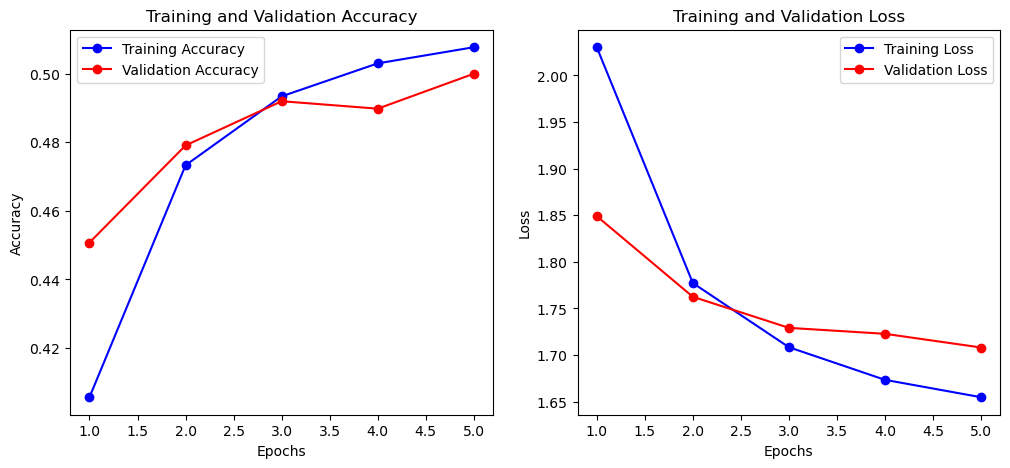

In [ ]:
# Plot training and validation accuracy
epochs = range(1, len(train_acc_plot) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_plot, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc_plot, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_plot, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_plot, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model7.save('char_rnn_model_7.keras')

# Sequence length 200

In [30]:
# perform one-hot encoding of inputs and labels
sequence_length = 200 # I attempted this for Model 8 to 14
inputs, labels, char_indices, chars = generate_text(text, sequence_length)
print(inputs[0] + '\n' + labels[0])
X, y = encode_ohe_pairs(text, sequence_length, inputs)
print(X[0])
print(y[0])

Number of sequences: 181380
Unique characters: 35
the adventures of sherlock holmes by sir arthur conan doyle   i. a scandal in bohemia  ii. the red-headed league iii. a case of identity  iv. the boscombe valley mystery   v. the five orange pips  vi.
 
Vectorization...
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False]


In [31]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

### Model #8 LSTM RMSprop, decrease learning rate and decrease the dropout and recurrent dropout

In [ ]:
# Build the Model
model8 = keras.models.Sequential()
model8.add(layers.LSTM(128, dropout = 0.005, recurrent_dropout = 0.005, input_shape=(sequence_length, len(chars))))
model8.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.RMSprop(learning_rate=0.05)
model8.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model8.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          83,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 35)                  │           4,515 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,483 (345.64 KB)

 Trainable params: 88,483 (345.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Lists to store accuracy and loss for training and validation
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

In [ ]:
# Training the model
for epoch in range(1, 6): # 5 epochs
    print('epoch', epoch)
    
    # Fit the model for 1 epoch on the available training data
    history = model8.fit(X, y, batch_size=128, epochs=1, validation_split=0.2)

    # Store training and validation metrics
    train_acc_list.append(history.history['acc'])
    train_loss_list.append(history.history['loss'])
    val_acc_list.append(history.history['val_acc'])
    val_loss_list.append(history.history['val_loss'])                        
    
    # Select a text seed at random
    start_index = random.randint(0, len(text) - sequence_length - 1)
    generated_text = text[start_index: start_index + sequence_length]
    print('--- Generating with seed: "' + generated_text + '"')
   
    
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # Generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, sequence_length, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model8.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 1038s 909ms/step - acc: 0.1772 - loss: 3.8433 - val_acc: 0.4335 - val_loss: 1.8916
--- Generating with seed: "cted. therewas a cheetah, too; perhaps we might find it upon our shouldersat any moment. i confess that i felt easier in my mind when,after following holmes' example and slipping off my shoes, ifound "
------ temperature: 0.2
cted. therewas a cheetah, too; perhaps we might find it upon our shouldersat any moment. i confess that i felt easier in my mind when,after following holmes' example and slipping off my shoes, ifound to sat to the cark to the sell some to the soll to the sound to the some to the some to the some to the to the sell with the some the sell to the sively of the some to the seet to the some to the sell, said to the soll to the sear to some to the soll to the clarter and so to the seent to the some to sake to the some to the bing to the soll and to sat the sell into sat the some to the with the some
------ temperature: 0.5


In [ ]:
# Flatten accuracy and loss lists
train_acc_plot = [j for i in train_acc_list for j in i]
train_loss_plot = [j for i in train_loss_list for j in i]
val_acc_plot = [j for i in val_acc_list for j in i]
val_loss_plot = [j for i in val_loss_list for j in i]

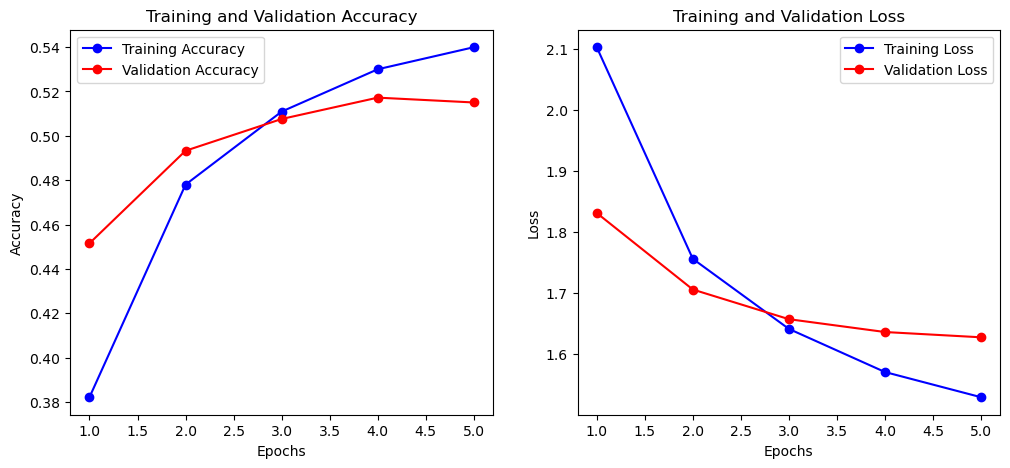

In [ ]:
# Plot training and validation accuracy
epochs = range(1, len(train_acc_plot) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_plot, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc_plot, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_plot, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_plot, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model8.save('char_rnn_model_8.keras')

### Model #9 LSTM Adam Increase Model Capacity to 256

In [32]:
# Build the Model
model9 = keras.models.Sequential()
model9.add(layers.LSTM(256, input_shape=(sequence_length, len(chars))))
model9.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.01)
model9.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model9.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 256)                 │         299,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 35)                  │           8,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 308,003 (1.17 MB)

 Trainable params: 308,003 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Lists to store accuracy and loss for training and validation
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

In [34]:
# Training the model
for epoch in range(1, 6): # 5 epochs
    print('epoch', epoch)
    
    # Fit the model for 1 epoch on the available training data
    history = model9.fit(X, y, batch_size=128, epochs=1, validation_split=0.2)

    # Store training and validation metrics
    train_acc_list.append(history.history['acc'])
    train_loss_list.append(history.history['loss'])
    val_acc_list.append(history.history['val_acc'])
    val_loss_list.append(history.history['val_loss'])                        
    
    # Select a text seed at random
    start_index = random.randint(0, len(text) - sequence_length - 1)
    generated_text = text[start_index: start_index + sequence_length]
    print('--- Generating with seed: "' + generated_text + '"')
   
    
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # Generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, sequence_length, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model9.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 3330s 3s/step - acc: 0.3101 - loss: 2.4004 - val_acc: 0.4537 - val_loss: 1.8416
--- Generating with seed: "and type,leaves a similar mark, but only on the left arm, and on the sideof it farthest from the thumb, instead of being right across thebroadest part, as this was. i then glanced at her face, and,obs"
------ temperature: 0.2
and type,leaves a similar mark, but only on the left arm, and on the sideof it farthest from the thumb, instead of being right across thebroadest part, as this was. i then glanced at her face, and,obse have to the stance the street the stant the strong the bant the stance the street the statter had the street the street and the stance to the street and the street and the street and the stance the stant the stance to the street the band the stanter to the door the street and the strong the street the stance and the stouth the stone the conter the ston the street the street and the lang the stan
------ temperature: 0.5
sta

In [35]:
# Flatten accuracy and loss lists
train_acc_plot = [j for i in train_acc_list for j in i]
train_loss_plot = [j for i in train_loss_list for j in i]
val_acc_plot = [j for i in val_acc_list for j in i]
val_loss_plot = [j for i in val_loss_list for j in i]

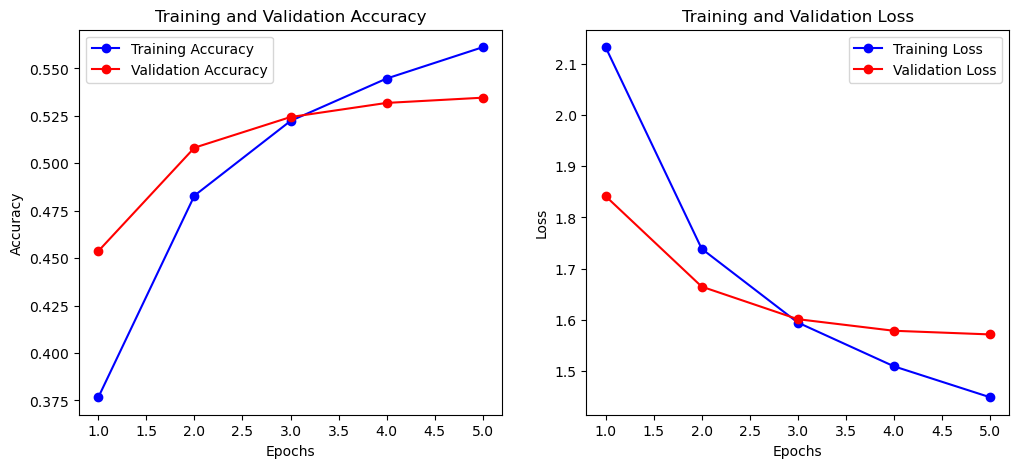

In [36]:
# Plot training and validation accuracy
epochs = range(1, len(train_acc_plot) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_plot, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc_plot, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_plot, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_plot, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [37]:
# Save the Model
model9.save('char_rnn_model_9.keras')

### Model #11 GRU RMSprop Base Sequence length 200

In [ ]:
# Build the Model
model11 = keras.models.Sequential()
model11.add(layers.GRU(512, input_shape=(sequence_length, len(chars))))
model11.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.RMSprop(learning_rate=0.001)
model11.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model11.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 512)                 │         843,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 35)                  │          17,955 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 861,219 (3.29 MB)

 Trainable params: 861,219 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Lists to store accuracy and loss for training and validation
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

In [ ]:
# Training the model
for epoch in range(1, 6): # 5 epochs
    print('epoch', epoch)
    
    # Fit the model for 1 epoch on the available training data
    history = model11.fit(X, y, batch_size=128, epochs=1, validation_split=0.2)

    # Store training and validation metrics
    train_acc_list.append(history.history['acc'])
    train_loss_list.append(history.history['loss'])
    val_acc_list.append(history.history['val_acc'])
    val_loss_list.append(history.history['val_loss'])                        
    
    # Select a text seed at random
    start_index = random.randint(0, len(text) - sequence_length - 1)
    generated_text = text[start_index: start_index + sequence_length]
    print('--- Generating with seed: "' + generated_text + '"')
   
    
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # Generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, sequence_length, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model11.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 3956s 3s/step - acc: 0.2751 - loss: 2.5602 - val_acc: 0.3696 - val_loss: 2.1522
--- Generating with seed: "red that i had not.his face fell immediately.'dear me!' he said gravely, 'that is very serious indeed! i amsorry to hear you say that. the fund was, of course, for thepropagation and spread of the red"
------ temperature: 0.2
red that i had not.his face fell immediately.'dear me!' he said gravely, 'that is very serious indeed! i amsorry to hear you say that. the fund was, of course, for thepropagation and spread of the redere to the lough a doure and at in the lough the look he the in the latt of the coure ware the in the inge the seand the mack it the lough the coome fore the coure to the and and the wis the wis were the look hat he and it and i salled the with the cound the mere the lough the lough the pound the mere the mere the could the mere the ing the in the and the coure the waid the could the and it and th
------ temperature: 0.5
the

In [ ]:
# Flatten accuracy and loss lists
train_acc_plot = [j for i in train_acc_list for j in i]
train_loss_plot = [j for i in train_loss_list for j in i]
val_acc_plot = [j for i in val_acc_list for j in i]
val_loss_plot = [j for i in val_loss_list for j in i]

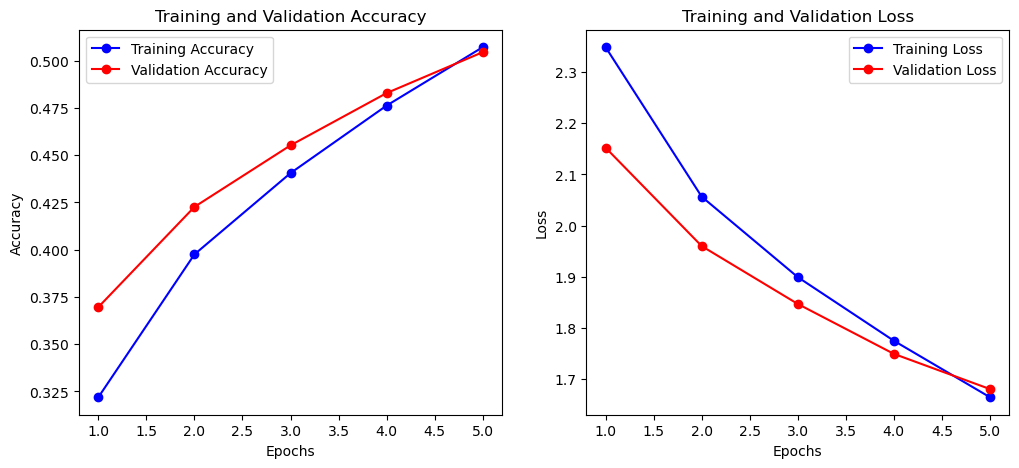

In [ ]:
# Plot training and validation accuracy
epochs = range(1, len(train_acc_plot) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_plot, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc_plot, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_plot, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_plot, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model11.save('char_rnn_model_11.keras')

### Model #13  is just Model 9 but 10 epochs

In [ ]:
# Build the Model
model13 = keras.models.Sequential()
model13.add(layers.LSTM(256, input_shape=(sequence_length, len(chars))))
model13.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.01)
model13.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model13.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                       │ (None, 256)                 │         299,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 35)                  │           8,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 308,003 (1.17 MB)

 Trainable params: 308,003 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Lists to store accuracy and loss for training and validation
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

In [ ]:
# Training the model
for epoch in range(1, 11): # 5 epochs
    print('epoch', epoch)
    
    # Fit the model for 1 epoch on the available training data
    history = model13.fit(X, y, batch_size=128, epochs=1, validation_split=0.2)

    # Store training and validation metrics
    train_acc_list.append(history.history['acc'])
    train_loss_list.append(history.history['loss'])
    val_acc_list.append(history.history['val_acc'])
    val_loss_list.append(history.history['val_loss'])                        
    
    # Select a text seed at random
    start_index = random.randint(0, len(text) - sequence_length - 1)
    generated_text = text[start_index: start_index + sequence_length]
    print('--- Generating with seed: "' + generated_text + '"')
   
    
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # Generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, sequence_length, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model13.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 5179s 5s/step - acc: 0.3065 - loss: 2.4166 - val_acc: 0.4503 - val_loss: 1.8395
--- Generating with seed: "as, and of how very useful theywould be to me. 'not at all,' said i, 'i shall be very happy toaccommodate myself to your wishes. i should like, however, tounderstand a little more clearly what it is t"
------ temperature: 0.2
as, and of how very useful theywould be to me. 'not at all,' said i, 'i shall be very happy toaccommodate myself to your wishes. i should like, however, tounderstand a little more clearly what it is that i was the for the post and the shall and and the shall the shall that i have the shall the parter and that i was and the said the said had the shall from the statter that i was a shall that i have said holmes shall the sto the said the shall the shall the shall the said the post and the sto the post and the was the paster that and she was a said the stake that and the shall that i have said he
------ temperature: 0.5
 sa

have to me has doctor for an instant and open the fire that he would not ady and a little from a joking as i can the been for the man who have her more persely just a percein, i will not be a sight and indee to up no ?i can seven it?i' dreaked witnge, neaked, and now an our an a headsensed. as a gavy wean, do not keeps.they do not in above stary side. he was ene oafty meanitap eased all the son at younger swong so. i saw have to havenot than her booch was nor hearly we trueg hemr. it sufper, you will you do? the grime or a sineer or the corner extent of the time if i be his consident room.' he
------ temperature: 1.2
 younger swong so. i saw have to havenot than her booch was nor hearly we trueg hemr. it sufper, you will you do? the grime or a sineer or the corner extent of the time if i be his consident room.' he had remarked?i saw out his haligantly. me shouldcalmostanture air lets, said he well, she wasualded picse?but those to night,there at uablyman, who is picion whichyou own in 

In [ ]:
# Flatten accuracy and loss lists
train_acc_plot = [j for i in train_acc_list for j in i]
train_loss_plot = [j for i in train_loss_list for j in i]
val_acc_plot = [j for i in val_acc_list for j in i]
val_loss_plot = [j for i in val_loss_list for j in i]

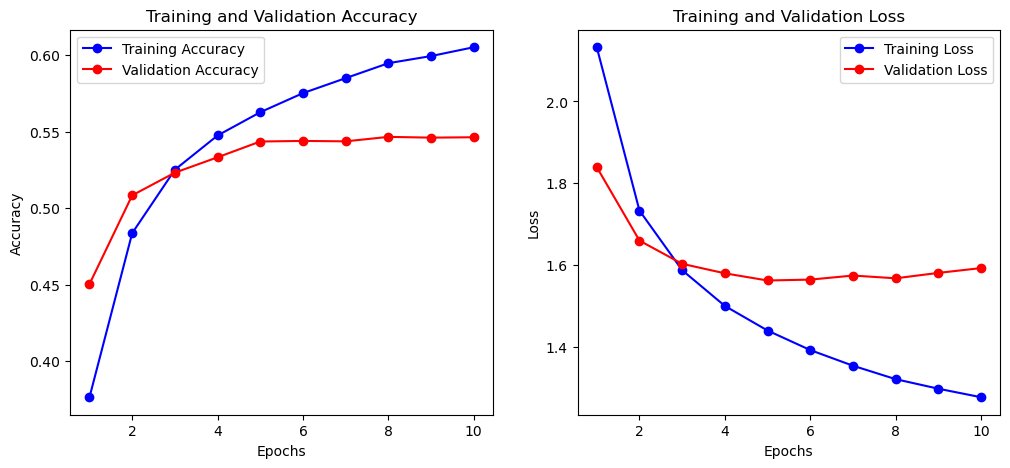

In [ ]:
# Plot training and validation accuracy
epochs = range(1, len(train_acc_plot) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_plot, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc_plot, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_plot, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_plot, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model13.save('char_rnn_model_13.keras')

# Sequence Length 150

In [45]:
# perform one-hot encoding of inputs and labels
sequence_length = 150
inputs, labels, char_indices, chars = generate_text(text, sequence_length)
print(inputs[0] + '\n' + labels[0])
X, y = encode_ohe_pairs(text, sequence_length, inputs)
print(X[0])
print(y[0])

Number of sequences: 181397
Unique characters: 35
the adventures of sherlock holmes by sir arthur conan doyle   i. a scandal in bohemia  ii. the red-headed league iii. a case of identity  iv. the bosc
o
Vectorization...
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False]


In [46]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

### Model 14 LSTM Adam Win Size 300

In [57]:
# Build the Model
model14 = keras.models.Sequential()
model14.add(layers.LSTM(512, input_shape=(sequence_length, len(chars))))
model14.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.01)
model14.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model14.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 512)                 │       1,122,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 35)                  │          17,955 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,140,259 (4.35 MB)

 Trainable params: 1,140,259 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Lists to store accuracy and loss for training and validation
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

In [59]:
# Training the model
for epoch in range(1, 6): # 5 epochs
    print('epoch', epoch)
    
    # Fit the model for 1 epoch on the available training data
    history = model14.fit(X, y, batch_size=512, epochs=1, validation_split=0.2)

    # Store training and validation metrics
    train_acc_list.append(history.history['acc'])
    train_loss_list.append(history.history['loss'])
    val_acc_list.append(history.history['val_acc'])
    val_loss_list.append(history.history['val_loss'])                        
    
    # Select a text seed at random
    start_index = random.randint(0, len(text) - sequence_length - 1)
    generated_text = text[start_index: start_index + sequence_length]
    print('--- Generating with seed: "' + generated_text + '"')
   
    
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # Generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, sequence_length, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model14.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
284/284 ━━━━━━━━━━━━━━━━━━━━ 2730s 10s/step - acc: 0.2237 - loss: 2.8292 - val_acc: 0.3700 - val_loss: 2.1406
--- Generating with seed: "sed land here, and we can't have tomfoolery of this kind.where does the thing come from?''from dundee,' i answered, glancing at the postmark.'some pre"
------ temperature: 0.2
sed land here, and we can't have tomfoolery of this kind.where does the thing come from?''from dundee,' i answered, glancing at the postmark.'some pres and in the sour the the tour the sould and in and the cound of the sure the the sing the tore the the the the tound on the the the sere of the the the the the the tout he the the the the the the stor the the the the the tore surd and of the sure the the the the the the the the the tour in the with the toure the sere the the the the the the sure the sing the tour the the pore the the the the the 
------ temperature: 0.5
e the the the the the the the the tour in the with the toure the sere the the the the the the sure the s

fields. on examining it, however, i found that this deposit was acomparatively small one, and that it formed a link between twovery much larger ones upon the street and the street in the was a smill my hat some stronge of the stained of the street to the was a smill the street and the was a carried to the secontrement of the street the street and the street the street the was a smill the stained in the street of the secontrest to the off to the ont of the off to the strong the street and the one of the street of the street and he said the stree
------ temperature: 0.5
n the street of the secontrest to the off to the ont of the off to the strong the street and the one of the street of the street and he said the street to me a the start of the place, the really on the come.but the ont of the was been the was not for you show my hat he was stained to the seen in whence the man upon the so that the sat it which he had not be the face for his last the sen to and a watters of the inture of t

In [60]:
# Flatten accuracy and loss lists
train_acc_plot = [j for i in train_acc_list for j in i]
train_loss_plot = [j for i in train_loss_list for j in i]
val_acc_plot = [j for i in val_acc_list for j in i]
val_loss_plot = [j for i in val_loss_list for j in i]

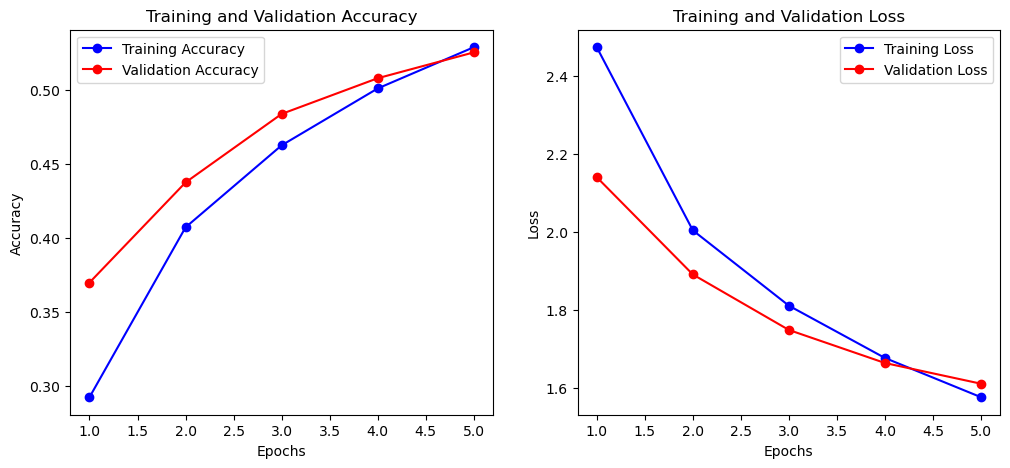

In [61]:
# Plot training and validation accuracy
epochs = range(1, len(train_acc_plot) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_plot, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc_plot, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_plot, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_plot, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [62]:
# Save the Model
model14.save('char_rnn_model_14.keras')

## Step 3 – Use the Best Model to make prediction

* the game is afoo (t) ## the iconic phrase in the sherlock holmes series
* he nodde (d)
* deep learning is fu (n)

### Model 13 Evaluation

In [17]:
from tensorflow.keras import models
import numpy as np
model = models.load_model('char_rnn_model_13.keras')

In [18]:
# takes the user input
text_input = np.array([input("Enter a string of characters: ")])

Enter a string of characters: the game is afoo


In [19]:
# one-hot encode the user input
# Enter your code here:
def encode_test_text(text_input, maxlen): 
    print('Vectorization...')
    x = np.zeros((len(text_input), maxlen, len(chars)), dtype=bool)
    for i, sentence in enumerate(text_input):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
    return x

def predicta(preds):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    print(probas)
    return np.argmax(probas)

In [25]:
# show the model output using predict function
x = encode_test_text(text_input, sequence_length)
preds = model.predict(x, verbose=0)[0]
next_index = predicta(preds)
print(next_index)
next_char = chars[next_index]
print(f"The predicted next character for {text_input} is  {next_char}")

Vectorization...
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
20
The predicted next character for ['the game is afoo'] is  l


In [26]:
# takes the user input
text_input = np.array([input("Enter a string of characters: ")])

Enter a string of characters: he nodde


In [30]:
# show the model output using predict function
x = encode_test_text(text_input, sequence_length)
preds = model.predict(x, verbose=0)[0]
next_index = predicta(preds)
print(next_index)
next_char = chars[next_index]
print(f"The predicted next character for {text_input} is  {next_char}")

Vectorization...
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]
26
The predicted next character for ['he nodde'] is  r


In [31]:
# takes the user input
text_input = np.array([input("Enter a string of characters: ")])

Enter a string of characters: deep learning is fu


In [48]:
# show the model output using predict function
x = encode_test_text(text_input, sequence_length)
preds = model.predict(x, verbose=0)[0]
next_index = predicta(preds)
print(next_index)
next_char = chars[next_index]
print(f"The predicted next character for {text_input} is  {next_char}")

Vectorization...
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
15
The predicted next character for ['deep learning is fu'] is  g


### Model 14 Evaluation

In [65]:
from tensorflow.keras import models
import numpy as np
model = models.load_model('char_rnn_model_14.keras')

In [66]:
# takes the user input
text_input = np.array([input("Enter a string of characters: ")])

Enter a string of characters: the game is afoo


In [67]:
# one-hot encode the user input
def encode_test_text(text_input, maxlen): 
    print('Vectorization...')
    x = np.zeros((len(text_input), maxlen, len(chars)), dtype=bool)
    for i, sentence in enumerate(text_input):
        for t, char in enumerate(sentence):
            x[i, t, char_indices[char]] = 1
    return x

def predicta(preds):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    print(probas)
    return np.argmax(probas)

In [68]:
# show the model output using predict function
x = encode_test_text(text_input, sequence_length)
preds = model.predict(x, verbose=0)[0]
next_index = predicta(preds)
print(next_index)
next_char = chars[next_index]
print(f"The predicted next character for {text_input} is  {next_char}")

Vectorization...
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]
21
The predicted next character for ['the game is afoo'] is  m


In [115]:
# takes the user input
text_input = np.array([input("Enter a string of characters: ")])

Enter a string of characters: he nodde


In [119]:
# show the model output using predict function
x = encode_test_text(text_input, sequence_length)
preds = model.predict(x, verbose=0)[0]
next_index = predicta(preds)
print(next_index)
next_char = chars[next_index]
print(f"The predicted next character for {text_input} is  {next_char}")

Vectorization...
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
28
The predicted next character for ['he nodde'] is  t


In [113]:
# takes the user input
text_input = np.array([input("Enter a string of characters: ")])

Enter a string of characters: deep learning is fu


In [114]:
# show the model output using predict function
# Enter your code here:
x = encode_test_text(text_input, sequence_length)
preds = model.predict(x, verbose=0)[0]
next_index = predicta(preds)
print(next_index)
next_char = chars[next_index]
print(f"The predicted next character for {text_input} is  {next_char}")

Vectorization...
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]
22
The predicted next character for ['deep learning is fu'] is  n
